# CELLxGENE Discover Census scvi-tools initial autotune report

Author: Martin Kim (martinkim@berkeley.edu)

Date: 2023-09-28

## Introduction

To prepare for training an scVI model on the CELLxGENE Discover single-cell RNA-seq corpus and making cell embeddings queryable in the Census, we performed hyperparameter validation. This notebooks presents data from human and mouse autotune runs, summarizes key findings, and outlines future research directions. The goal is that, with the conclusions drawn in this notebook, we can confidently deliver a beta release of model embeddings through the Census and then iterate further from there.

Running this notebooks requires `matplotlib`, `pandas`, and `seaborn`. We start by importing some utility functions.

In [1]:
import os

from utils import (
    get_trial_dirs, 
    get_trial_ids, 
    get_trial_info, 
    get_trial_params, 
    get_trial_progress, 
    plot_trials,
)

## Methods

### Glossary

We start by presenting an overview of the model and training parameters referenced throughout this notebook, including their descriptions and default values currently in `scvi-tools`:

- `n_hidden`: Number of nodes per hidden layer in the encoder and decoder (default is `128`)
- `n_layers`: Number of hidden layers in the encoder and decoder (default is `1`)
- `n_latent`: Dimensionality of the model's latent space (default is `10`)
- `lr`: Fixed learning rate of the optimizer (default is `1e-3`)
- `batch_size`: Size of the mini-batches seen during each training iteration (default is `128`)
- `var_activation`: Non-negative activation function over the posterior variance in the encoder (default is the exponential)

### Search spaces

The search space defines the model and training parameters we want to examine in order to understand their impact on model performance, specifically the validation loss. The following outlines the search spaces for tunable parameters, as well as any fixed hyperparameters that deviate from their default settings in `scvi-tools`:

```{python}
v1_search_space = {
    "n_hidden": [128, 256, 512]
    "n_layers": [1, 10, 25],
    "n_latent": [10, 50, 100],
    "lr": [1e-2, 1e-3, 1e-4],
    "batch_size": [512, 1024, 2048],
}
v1_non_default_model_parameters = {
    "var_activation": "softplus"
}
```
The search space above was tuned over with a random subset (1/10) of the human data (~3,000,000 cells), the full human data (~30,000,000 cells), and the full mouse data (~3,000,000 cells). The goal of this first search space was to generally explore how the optimal model size (`n_hidden`, `n_layers`, `n_latent`) scales with the size of the data as well as understanding the role that the learning rate and batch size play in the stability of model training.

After the results of the first search space were analyzed, the behavior of changing `n_layers` and `n_latent` was inconclusive, thus the second search space included additional values for these along with fixed non-default values for all other parameters.

```{python}
v2 = {
    "n_layers": [1, 2, 5],
    "n_latent": [50, 100, 200],
}
v2_non_default_model_parameters = {
    "n_hidden": 512,
    "var_activation": "softplus",
}
v2_non_default_train_parameters = {
    "lr": 1e-4,
    "batch_size": 1024,
}
```

Note that both search spaces set the variance activation to the softplus instead of the default exponential. This is because, prior to the autotune runs, it was observed that the exponential led to frequent NaN values during model training. The softplus has anecdotally led to more stable training.

### Autotune algorithms

Two key components in an autotune run are the scheduler and search algorithms. The former slates which trials (*i.e.* a model with a set of hyperparameters sampled from the search space) are to run concurrently at a given time and for how many training epochs, and the latter determines how new sets of hyperparameters are sampled from the search space. In `scvi.autotune`, we rely on [Ray Tune](https://docs.ray.io/en/latest/tune/index.html) for both of these components. In particular, we used the following for all autotune runs:

- [Asynchronous HyperBand scheduler](https://openreview.net/forum?id=S1Y7OOlRZ): Adaptively assigns more computational resources (*i.e.* training epochs) to more promising candidates (*i.e.* trials with lower validation losses that decrease quickly) and prunes less promising ones early. It does so in an asynchronous manner such that trials don't need to wait for one another to complete.
- [Tree-structured Parzen Estimators](https://proceedings.neurips.cc/paper_files/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf): Estimates the objective function (*i.e.* validation loss) as separate distributions for good and bad hyperparameters. Using information from trials that have completed, it updates its approximation and uses it to sample new hyperparameters based on the greatest Expected Improvement.

The combination of these two algorithms ensures that underperforming trials are stopped early and that new trials are sampled in a more sophisticated manner compared to, say, random sampling. This ensures that computing resources (*i.e.* GPU time) are utilized more efficiently.

A large downside of using these types of algorithms is that we might end up terminating potentially good trials (*e.g.* models that initially perform poorly but end up outperforming other models) due to the aggressive pruning behavior of the scheduler or focusing too much on an unpromising area of the search space if the search algorithm estimation is not very accurate.

## Results

We start by reading in the log files for each autotune experiment, and then we will inspect the training curves generated by the experiments with respect to each hyperparameter.

In [2]:
EXPERIMENT_IDS = [
    "2023_08_22_human_full", # v1
    "2023_08_22_human_tenth", # v1
    "2023_09_06_mouse_full", # v1
    "2023_09_12_human_full", # v2
    "2023_09_12_mouse_full", # v2
]
v1_search_params = [
    "n_hidden",
    "n_layers",
    "n_latent",
    "lr",
    "batch_size",
]
v2_search_params = [
    "n_layers",
    "n_latent",
]
ROOT_DIR = "../logs"
V1_DATES = ("2023_08_22", "2023_09_06")
V2_DATES = ("2023_09_12")
TRIAL_IDS_KEY = "trial_ids"
TRIAL_PARAMS_KEY = "trial_params"
TRIAL_PROGRESS_KEY = "trial_progress"
TRIAL_INFO_KEY = "trial_info"

In [3]:
experiments = {}

for experiment_id in EXPERIMENT_IDS:
    if experiment_id.startswith(V1_DATES):
        search_params = v1_search_params
    elif experiment_id.startswith(V2_DATES):
        search_params = v2_search_params

    experiment_dir = os.path.join(ROOT_DIR, experiment_id)
    trial_dirs = get_trial_dirs(
        experiment_dir, 
        filter_incomplete=True, 
        filter_lightning=True
    )
    trial_ids = get_trial_ids(trial_dirs)

    trial_params = {
        trial_id: get_trial_params(
            experiment_dir, 
            trial_dir, 
            search_params
        ) for trial_id, trial_dir in zip(trial_ids, trial_dirs)
    }
    trial_progress = {
        trial_id: get_trial_progress(
            experiment_dir, 
            trial_dir
        ) for trial_id, trial_dir in zip(trial_ids, trial_dirs)
    }
    trial_info = get_trial_info(trial_params, trial_progress)

    experiments[experiment_id] = {
        TRIAL_IDS_KEY: trial_ids,
        TRIAL_PARAMS_KEY: trial_params,
        TRIAL_PROGRESS_KEY: trial_progress,
        TRIAL_INFO_KEY: trial_info,
    }

Missing progress.csv for _trainable_b6d775cc_1_batch_size=2048,lr=0.0100,n_hidden=256,n_latent=10,n_layers=10,var_activation=ref_ph_ecd03db6_2023-08-17_16-39-25
Missing progress.csv for _trainable_f8003819_45_batch_size=2048,lr=0.0100,n_hidden=256,n_latent=50,n_layers=1,var_activation=ref_ph_ecd03db6_2023-08-21_14-51-17
Missing progress.csv for _trainable_2d9a9cf5_141_batch_size=2048,lr=0.0100,n_hidden=128,n_latent=100,n_layers=25,var_activation=ref_ph_ecd03db6_2023-08-17_16-31-33
Missing progress.csv for _trainable_57c97f03_41_batch_size=512,lr=0.0001,n_hidden=512,n_latent=100,n_layers=25,var_activation=ref_ph_ecd03db6_2023-08-19_07-56-10
Missing progress.csv for _trainable_c000f380_147_batch_size=512,lr=0.0100,n_hidden=128,n_latent=100,n_layers=1,var_activation=ref_ph_ecd03db6_2023-08-17_16-31-43


Before diving into the results, we note the following caveats about hyperparameter optimization results in general:

- With any deep learning model, there is a certain amount of variability even between trials with the same set of hyperparameters due to random train-validation splits, mini-batch sampling during training, or due to CUDA using non-deterministic operations. This is mitigated on our end by using the same random seed for all trials, but despite this some amount of skepticism has to be applied to the results.
- As mentioned before, the choice of schedulers and search algorithms heavily influences which trials are to be run. Using more sophisticated algorithms than random sampling and FIFO scheduling can be beneficial, but these algorithms are not perfect and can give misleading results.
- For these autotune experiments, we focused on the validation loss, which is computed on a random split of 10% of the original data. While the validation loss can give a good indication on whether the model is overfitting, generalizing, converging, etc, it might not always be an accurate reflection of other aspects of the model we are interested in such as biological conservation in the latent space or integration with respect to technical covariates.

With that in mind, the interpretation of the results will highlight the following aspects of the model:

- Overfit: Occurs when the model fits the training data too well such that it does not generalize to the validation set. This can be inspected by comparing the relative difference between the training and validation losses, and also observing whether the validation decreases in the beginning and then goes back up again.
- Underfit: Occurs when the model is unable to fit the training or validation data performantly. This can be observed when neither the training or validation losses decrease quickly.
- Convergence: Occurs when the model reaches a point during training where the validation loss does not significantly increase or decrease with further iterations. 
- Stability: How steady the training and validation losses are throughout training, *i.e.* if there spikes in the curves or if the losses decrease monotonically or not.

### `n_hidden`

Here we plot the validation losses across 403 trials in the v1 full human data experiment, where each line represents a single trial. Trials are colored by `n_hidden`. Notice that trials have variable numbers of training epochs due to the scheduling behavior discussed earlier. The y-axis is truncated for clarity.

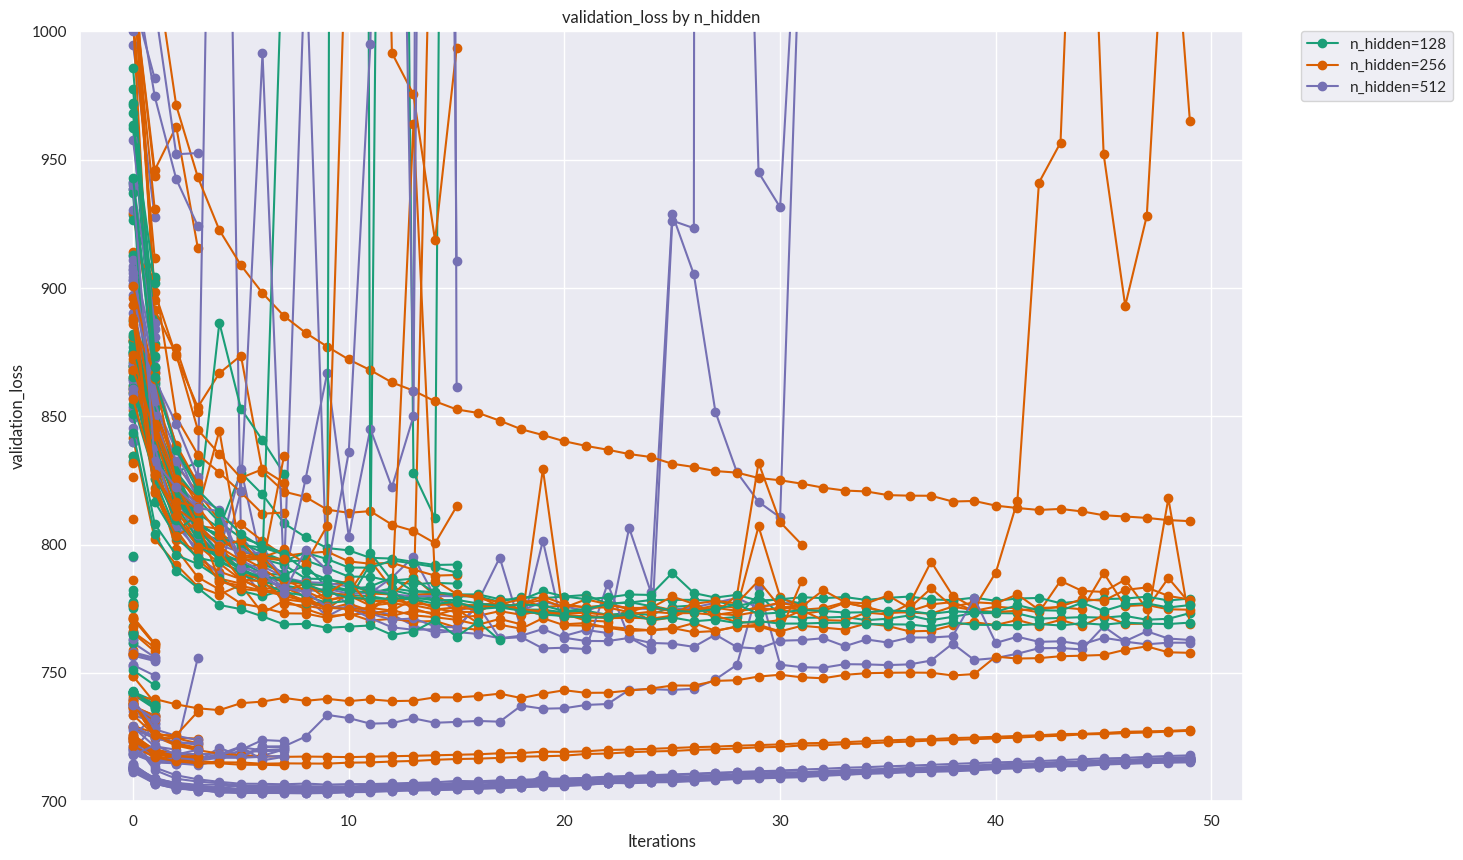

In [4]:
plot_trials(
    experiments["2023_08_22_human_full"][TRIAL_INFO_KEY],
    experiments["2023_08_22_human_full"][TRIAL_PROGRESS_KEY],
    experiments["2023_08_22_human_full"][TRIAL_PARAMS_KEY],
    "n_hidden",
    figsize=(15, 10),
    ylim=(700, 1000),
)

Observations:

- There is a clear difference in stability between various trials.
- Generally seems like trials with larger `n_hidden` (`256` and `512`) achieve lower validation losses and converge very quickly (around epoch 10).
- 

### `n_layers`

### `n_latent`

### `lr`

### `batch_size`

## Discussion